In [ ]:
from google.colab import files
files.upload()

Saving archive.zip to archive.zip


In [1]:

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [12]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

Dataset URL: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies
License(s): CC-BY-NC-SA-4.0
100% 247M/247M [00:14<00:00, 19.7MB/s]
100% 247M/247M [00:14<00:00, 17.9MB/s]


In [3]:
!unzip /content/satellite-images-of-water-bodies.zip

Archive:  /content/satellite-images-of-water-bodies.zip
replace Water Bodies Dataset/Images/water_body_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import random
import glob

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
image_path = "/content/Water Bodies Dataset/Images/*.jpg"
mask_path = "/content/Water Bodies Dataset/Masks/*.jpg"



image_paths = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_paths = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, size):
    # Resize the image to the specified size
    resized_image = cv2.resize(image, size)
    return resized_image

def resize_mask(mask, size):
    # Convert the mask to grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Resize the mask to the specified size
    resized_mask = cv2.resize(mask_gray, size, interpolation=cv2.INTER_NEAREST)
    resized_mask = np.expand_dims(resized_mask, axis=2)
    return resized_mask



# Define the desired size
target_size = (128,128)

image_list = []
mask_list = []

for image_path, mask_path in zip(image_paths, mask_paths):
    # Load the image and mask
    image = plt.imread(image_path).astype(np.float32) / 255.
    mask = plt.imread(mask_path).astype(np.float32) / 255.

    # Resize the image and mask
    resized_image = resize_image(image, target_size)
    resized_mask = resize_mask(mask, target_size)

    image_list.append(resized_image)
    mask_list.append(resized_mask)

# Convert the image and mask lists to arrays
image_array = np.array(image_list)
mask_array = np.array(mask_list)

# Check the shapes of the resized image and mask arrays
print("Resized image array shape:", image_array.shape)
print("Resized mask array shape:", mask_array.shape)


Resized image array shape: (2841, 128, 128, 3)
Resized mask array shape: (2841, 128, 128, 1)


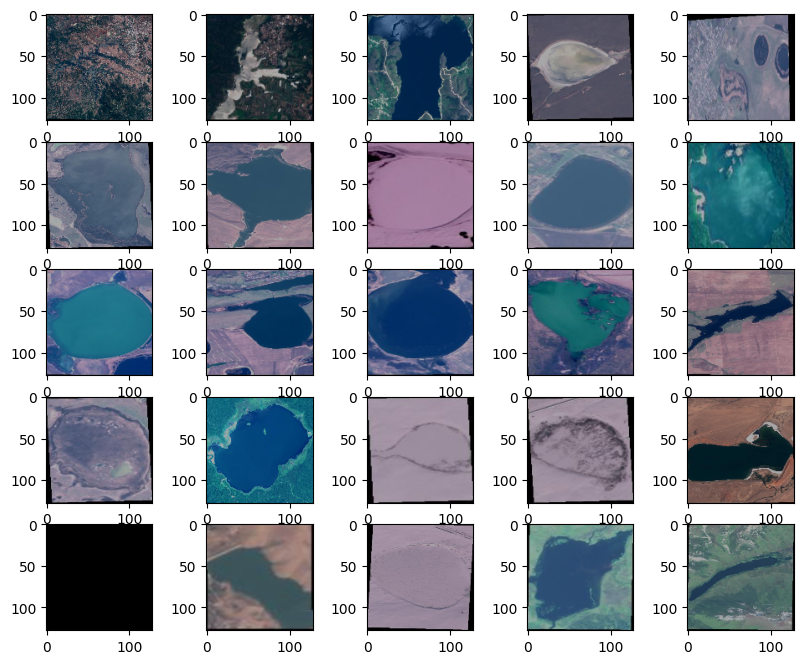

In [14]:

def show_img(img, nrows=5, ncols=5, figsize=(10, 8)):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  id_img = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i][j].imshow(img[id_img])
      id_img += 1


show_img(image_array)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_array,mask_array, test_size=0.2, random_state=23)

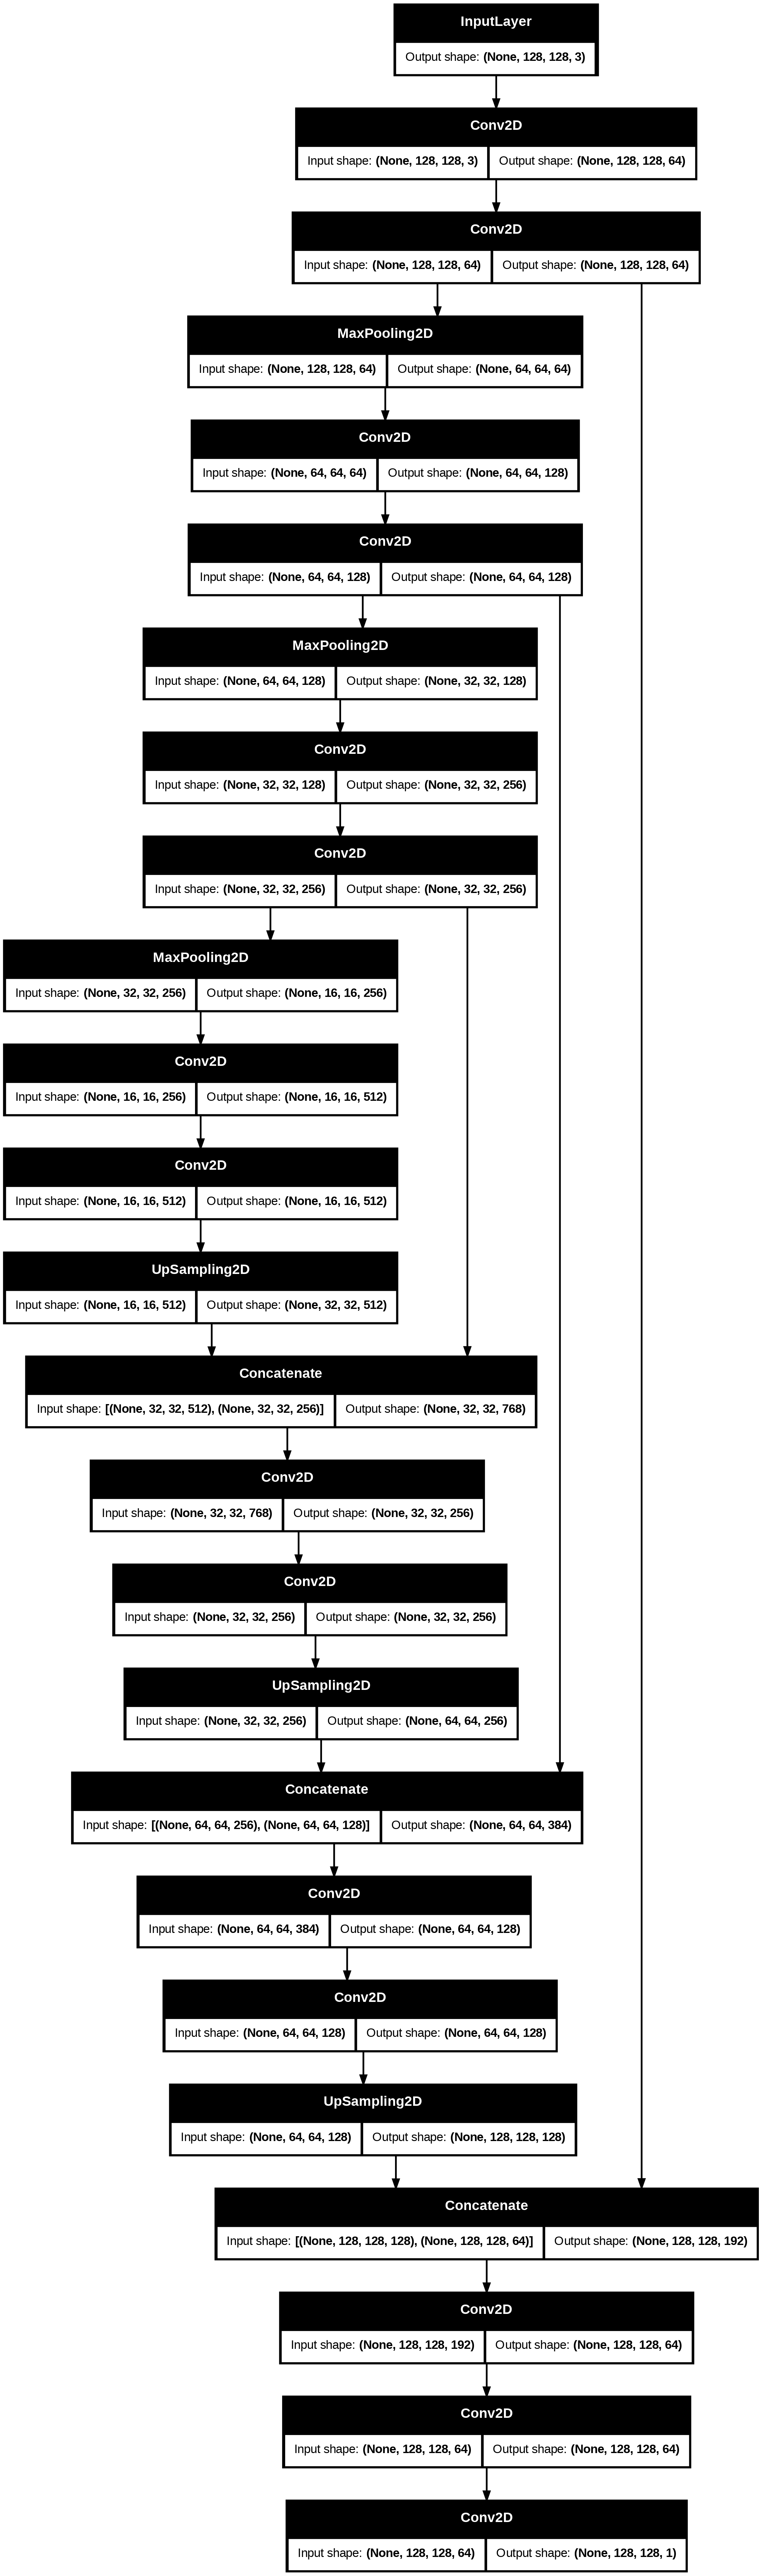

In [16]:
import tensorflow as tf

# Define input
x = tf.keras.layers.Input((128, 128, 3))

# Encoder
enc1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
enc2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(enc1)
enc3 = tf.keras.layers.MaxPooling2D((2, 2))(enc2)

enc4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc3)
enc5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(enc4)
enc6 = tf.keras.layers.MaxPooling2D((2, 2))(enc5)

enc7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc6)
enc8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(enc7)
enc9 = tf.keras.layers.MaxPooling2D((2, 2))(enc8)

# Bottleneck
bottleneck = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(enc9)
bottleneck = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(bottleneck)

# Decoder
dec1 = tf.keras.layers.UpSampling2D((2, 2))(bottleneck)
dec1 = tf.keras.layers.Concatenate()([dec1, enc8])  # Skip connection from enc8
dec1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(dec1)
dec1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(dec1)

dec2 = tf.keras.layers.UpSampling2D((2, 2))(dec1)
dec2 = tf.keras.layers.Concatenate()([dec2, enc5])  # Skip connection from enc5
dec2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec2)
dec2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(dec2)

dec3 = tf.keras.layers.UpSampling2D((2, 2))(dec2)
dec3 = tf.keras.layers.Concatenate()([dec3, enc2])  # Skip connection from enc2
dec3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec3)
dec3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(dec3)

# Output layer
output = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(dec3)

# Create model
model = tf.keras.Model(inputs=x, outputs=output)

# Display model summary
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/content/Water Bodies Dataset/watermodel.keras",save_best_only=True)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
history = model.fit(X_train,y_train, batch_size=16, epochs=30,validation_data=(X_test, y_test))







Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 309ms/step - accuracy: 0.6523 - loss: 0.6216 - val_accuracy: 0.6781 - val_loss: 0.5289
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 34s 165ms/step - accuracy: 0.6999 - loss: 0.4859 - val_accuracy: 0.7142 - val_loss: 0.4655
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.7044 - loss: 0.4858 - val_accuracy: 0.7082 - val_loss: 0.4685
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.7103 - loss: 0.4631 - val_accuracy: 0.6716 - val_loss: 0.5028
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.7287 - loss: 0.4436 - val_accuracy: 0.7373 - val_loss: 0.4337
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7445 - loss: 0.4184 - val_accuracy: 0.7510 - val_loss: 0.4193
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.7573 - loss: 0.4061 - val_accuracy: 0.7731 - val_loss: 0.3700
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.7711 - loss: 0

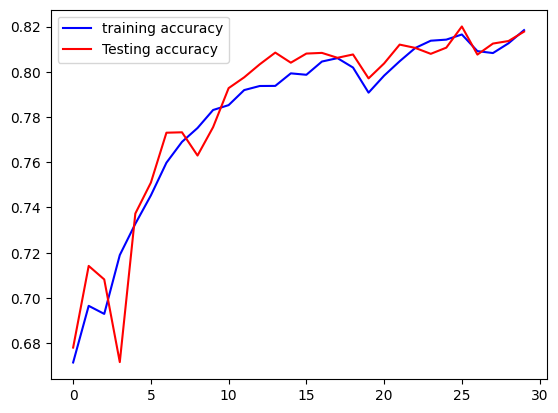

In [23]:
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

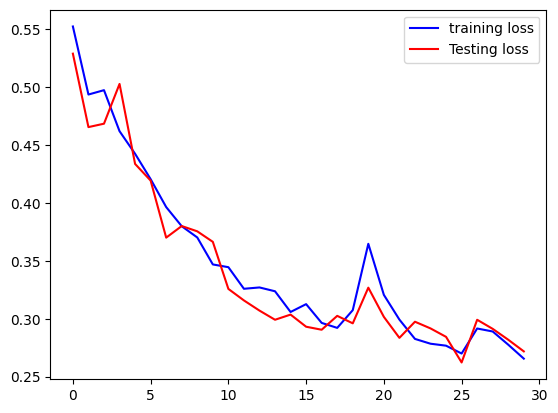

In [24]:
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


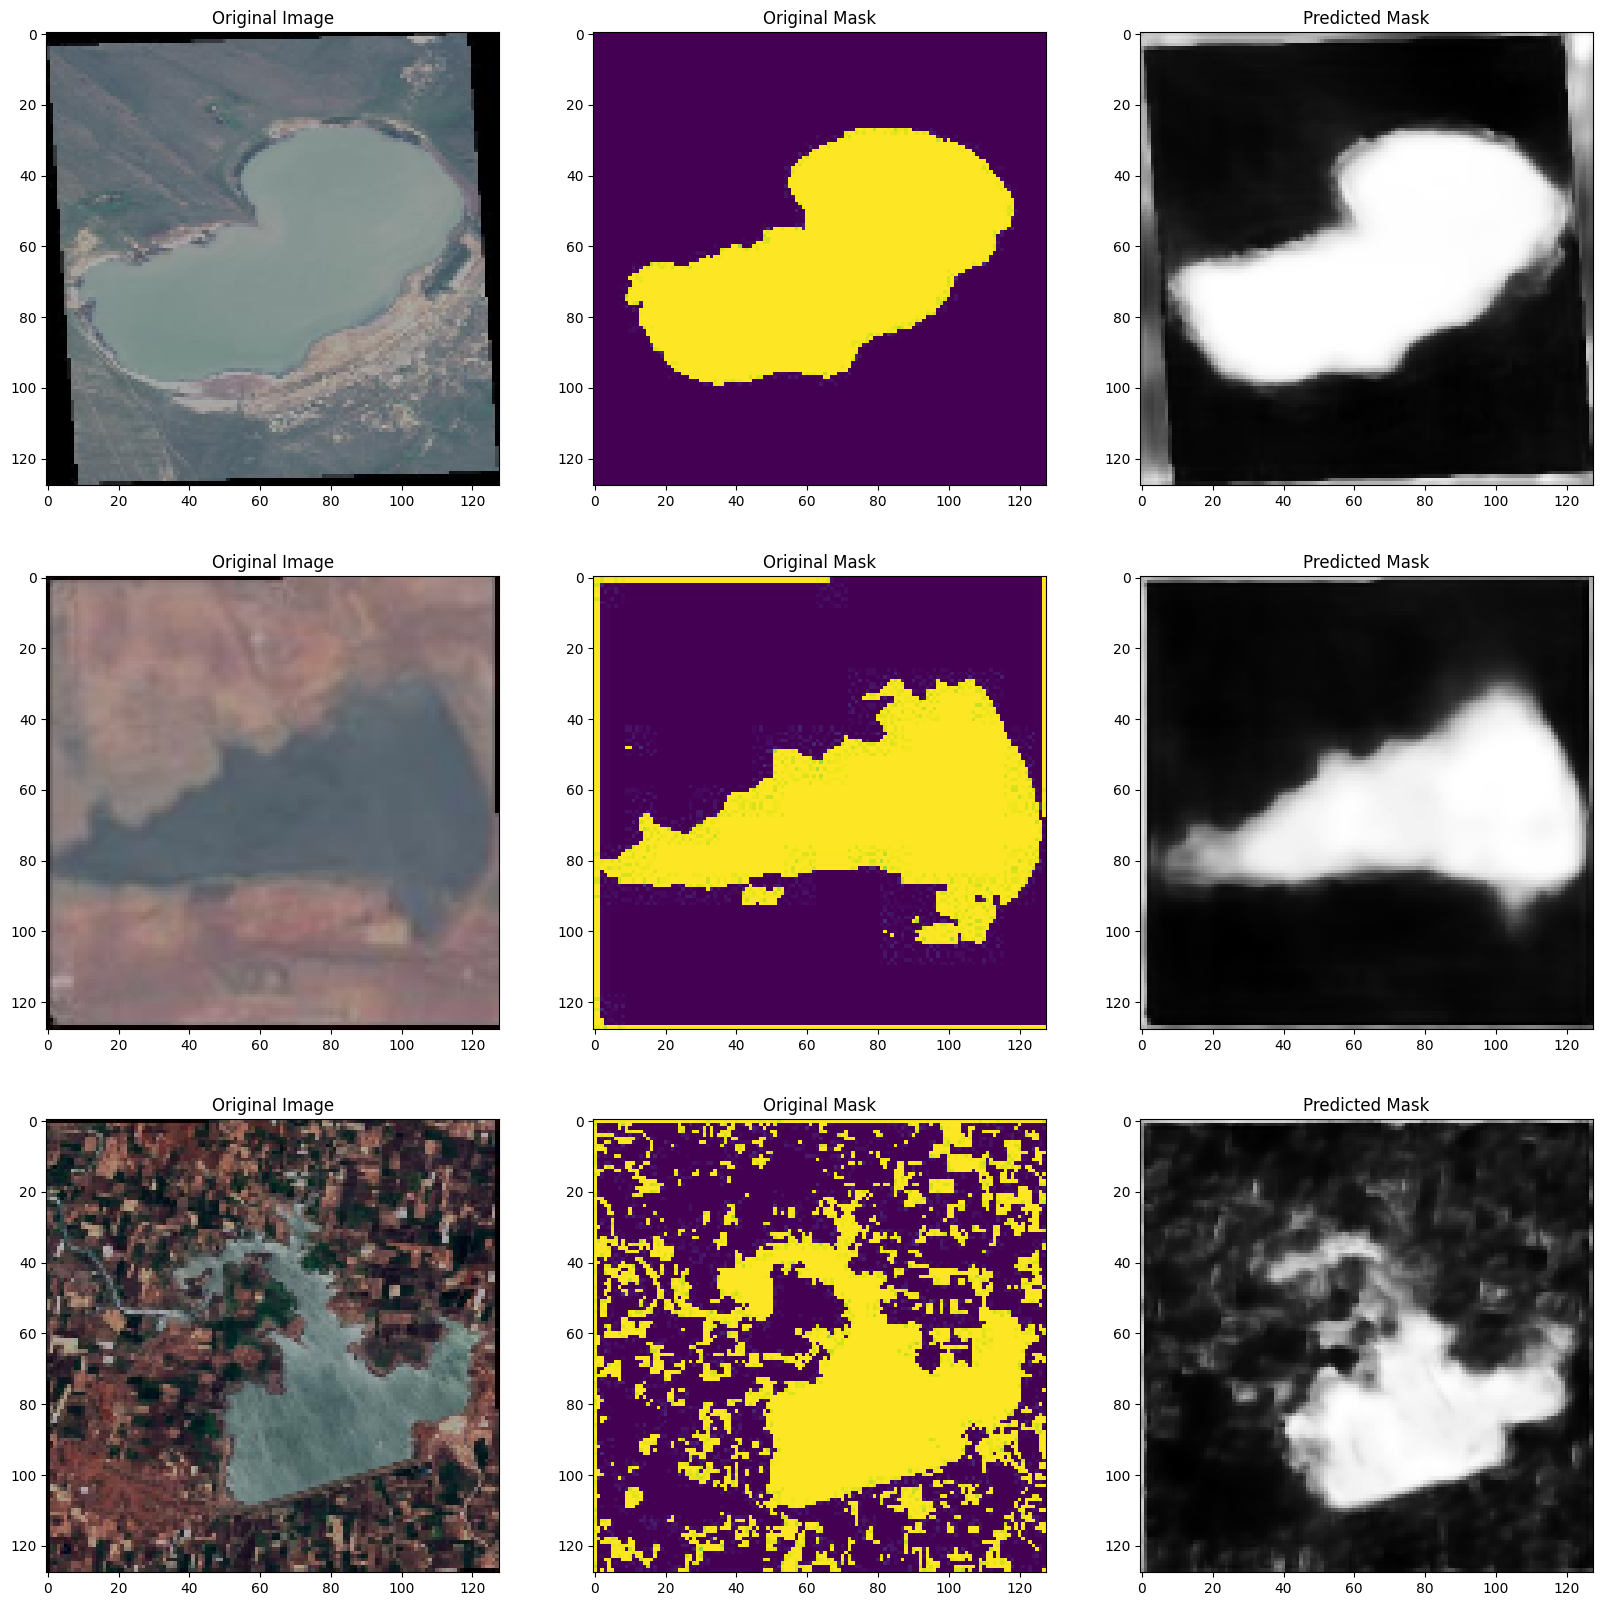

In [25]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,100)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')